# Benchmarking NN priors

## Look first at the base nn surrogate model which maps simulated inputs to simulated outputs

In [6]:
## benchmarking nn

import json
import torch
import sys
sys.path.append("../")

# get model metadata
model_info = json.load(open("../configs/model_info.json"))
pv_info = json.load(open("../configs/pvinfo.json"))

# get tranformers for simulation -> PV values
from sim_pv_transform import create_transformer
sim_to_pv_transformer = create_transformer(pv_info, model_info["model_in_list"])

# create surrogate model and transformers for NN normalization
from injector_surrogate import Surrogate, create_nn_transformers
nn_input_transformer, nn_output_transformer = create_nn_transformers(
    "../configs/normalization.json"
)

model = torch.load("torch_model.pt").double()
model.eval()

base_surrogate_model = Surrogate(
    model,
    model_info["model_in_list"],
    model_info["model_out_list"],
    nn_input_transformer,
    nn_output_transformer
)

print(base_surrogate_model.model_input_list)
print(base_surrogate_model.model_output_list)

['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value', 'distgen:total_charge:value', 'SOL1:solenoid_field_scale', 'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage', 'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg', 'QA01:b1_gradient', 'QA02:b1_gradient', 'QE01:b1_gradient', 'QE02:b1_gradient', 'QE03:b1_gradient', 'QE04:b1_gradient']
['sigma_x', 'sigma_y', 'sigma_z', 'norm_emit_x', 'norm_emit_y']


In [4]:
import numpy as np
raw_x_data = np.load("../data/x_raw_small.npy", allow_pickle=True)
raw_y_data = np.load("../data/y_raw_small.npy", allow_pickle=True)

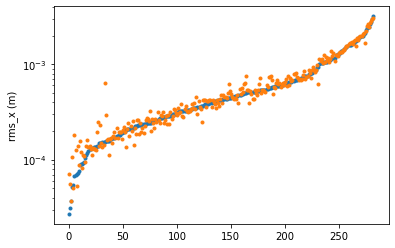

In [5]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
sort_idx = np.argsort(raw_y_data[:,0])
preds = base_surrogate_model(torch.tensor(raw_x_data).double(), return_log=True)

ax.semilogy(raw_y_data[:,0][sort_idx],'.')
ax.semilogy(preds[:,0][sort_idx],'.')
ax.set_ylabel("rms_x (m)");

## NN predictions from raw data to simulated outputs works

## Benchmark adaptive model that maps PVs to experimental values == simulated values

[[1.78240388e-04 1.44507552e-03 5.41841605e-04 1.41619208e-06
  1.19454314e-06 5.07514355e-04]
 [1.77929179e-04 8.52644415e-04 6.58277891e-04 1.18271848e-06
  1.13775509e-06 3.89500091e-04]
 [2.96901005e-04 2.08465254e-04 7.07188301e-04 1.67688133e-06
  9.01205564e-07 2.48784130e-04]
 ...
 [1.32902874e-03 1.50620285e-03 4.25769691e-04 5.83803289e-07
  5.84444217e-07 1.41484517e-03]
 [1.54127105e-03 1.73134395e-03 4.25180832e-04 5.95329883e-07
  5.82371458e-07 1.63354532e-03]
 [6.26852869e-04 6.92989723e-05 5.17625375e-04 7.59730645e-07
  9.72083994e-07 2.08423270e-04]]
tensor([ 1.1766e+00,  3.5380e+00,  2.5000e+02,  4.4720e-01, -8.2369e-04,
         1.3596e-02,  5.8000e+01,  2.7935e+00,  7.0000e+01, -9.8690e+00,
        -2.3205e+00,  2.6090e+00, -2.5998e+00, -7.7558e-01,  4.0487e+00,
        -2.5267e+00], dtype=torch.float64)
[0.00016864793055100324 0.0015950831162394174 0.0005424259007070327
 1.3960860485109939e-06 1.1762668344852966e-06]


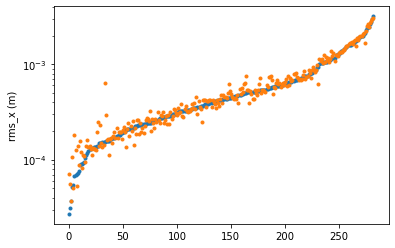

In [7]:
from adaptive_nn import AdaptiveNN

adaptive_nn = AdaptiveNN(base_surrogate_model, sim_to_pv_transformer)
adaptive_nn.eval()

# transform raw_x data to PV values
raw_x_pv = sim_to_pv_transformer(torch.tensor(raw_x_data))

# send to model
pred_pv = adaptive_nn(raw_x_pv).detach().numpy()
print(pred_pv)
# compare to true values
fig,ax = plt.subplots()
sort_idx = np.argsort(raw_y_data[:,0])

ax.semilogy(raw_y_data[:,0][sort_idx],'.')
ax.semilogy(pred_pv[:,0][sort_idx],'.')
ax.set_ylabel("rms_x (m)")
print(raw_x_pv[0])
print(raw_y_data[0])